# Introduction to Data Science
## Regularization and Model assessment

Spring 2017 - Prof. Foster Provost

Teacher Assistant: Maria L Zamora Maass


***

Import all of the packages we will need.

In [26]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

Create data with the script (you should be familiar with this after last class!)

### Regularization in logistic regression

Last class we saw that when fitting a logistic regression classifier, we try to find the set of weights, $\textbf{w}$, that maximize the fit function $g()$,

$\arg\max_\textbf{w} g(\textbf{x}, \textbf{w})$.

We can penalize our model for getting too complex by adding a penalty function and using the weight $\lambda$ to determine how much importance our optimization procedure should place on the penalty,

$\arg\max_\textbf{w} g(\textbf{x}, \textbf{w}) - \lambda \cdot \text{penalty}(\textbf{w})$.

The two most common type of regularization are $L_1$ and $L_2$ regularization.


In [35]:
# Get some data
target_name, variable_names, data, Y = data_tools.create_data()

# Grab the predictors with sufficient complexity (3rd order interaction terms)
X = data_tools.X(complexity=3)

X.tail()


,humor,number_pets,humor^2,humor^3
1795,15.726095,3.421895,247.310055,3889.221340
1796,18.287245,2.525489,334.423322,6115.681157
1797,24.366339,3.557690,593.718491,14466.746199
1798,22.905494,2.920013,524.661664,12017.634686
1799,21.120834,2.633541,446.089612,9421.784451


In [ ]:
# Plot different regularization values for L1 and L2 regularization
for regularization in ['L2', 'L1']:
    # Get a table of the model coefficients
    coefs = pd.DataFrame(columns=['C'] + list(X.columns))
    
    # Print what we are doing
    print "Fitting with %s regularization:" % regularization
    position = 0
    
    # Try some regularization values
    for i in range(-6, 3):
        # Modeling
        c = np.power(10.0, i)
        model = LogisticRegression(penalty=regularization.lower(), C=c)
        model.fit(X, Y)
        
        # Plotting
        position += 1
        plt.subplot(3, 3, position)
        data_tools.Decision_Surface(X, Y, model)
        plt.title("C = " + str(np.power(10.0, i)))
        
        # Update coefficient table
        coefs.loc[i] = [c] + list(model.coef_[0])
    # Print and plot
    print coefs.to_string(index=False)
    plt.tight_layout()
    plt.show()

### Receiver operating characteristic (ROC) curves

Here were are trying to predict if customers are given a credit card:

- Target: `Y_handson = 1` 
- Three features in `X_handson`: "earning", "geographic", and "experience".

Up until this point we have been using Accuracy (the number of records correctly classified divided by the total number of records). However, we saw that this does not always give us the "best" interpretation of our model's performance. Another way to measure the performance of a model is to use reciever operating characteristic **(ROC) curves**:

"A ROC graph is a two-dimensional plot of a classifier with false positive rate on the x axis against true positive rate on the y axis. As such, a ROC graph depicts relative trade-offs that a classifier makes between benefits (true positives) and costs (false positives). A discrete classifier is one that outputs only a class label (as opposed to a ranking). As already discussed, each such classifier produces a confusion matrix, which can be summarized by certain statistics regarding the numbers and rates of true positives, false positives, true negatives, and false negatives." 

"The lower left point **(0, 0) represents the strategy of never issuing a positive classification**; such a classifier commits no false positive errors but also gains no true positives. The opposite strategy, of unconditionally issuing positive classifications, is represented by the upper right point (1, 1). The point **(0, 1) represents perfect classification**, represented by a star. The diagonal line connect‐ ing (0, 0) to (1, 1) represents the policy of guessing a class."  

- _Provost, Foster, and Tom Fawcett. Data Science for Business: _
  _What you need to know about data mining and data-analytic thinking. " O'Reilly Media, Inc.", 2013._


<img src="dstools/ROC2.png" alt="Drawing" style="width: 600px;"/>
<img src="dstools/ROC1.png" alt="Drawing" style="width: 600px;"/>


Doing this in sklearn is relatively straight forward.

Let's create new data for this!!!! 

In [36]:

from dstools import data_tools
X, Y = data_tools.handson_data()
X.tail()


,earning,geographic,experience
3995,-2.833183,-5.066973,-5.947391
3996,0.481408,0.513775,-7.297304
3997,2.805390,-9.772152,-3.244860
3998,2.469796,-4.040490,-5.996876
3999,-6.977494,9.412709,-1.999144


Let's start by dividing our data into **training and test sets**.

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

We can now build and fit a model. Using this model, we will plot a *ROC curve*.

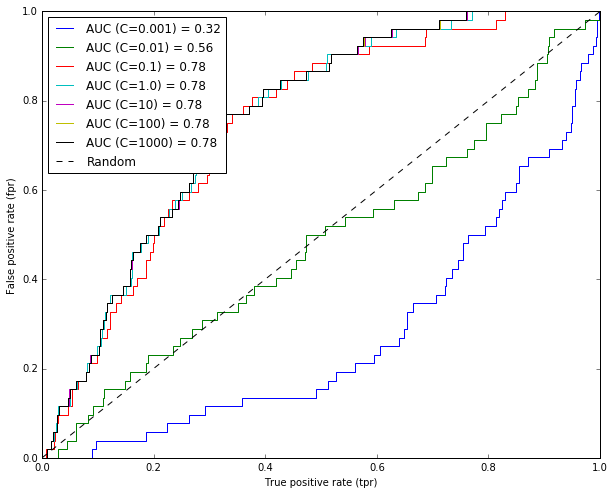

In [29]:
# Fit a logistic regression model
for c in [0.001, 0.01, 0.1, 1.0]:
    model = LogisticRegression(C=c)
    model.fit(X_train, Y_train)

    # Get the probability of Y_test records being = 1
    Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

    # Use the metrics.roc_curve function to get the true positive rate (tpr) and false positive rate (fpr)
    tpr, fpr, thresholds = metrics.roc_curve(Y_test, Y_test_probability_1)

    # Get the area under the curve (AUC)
    acc = np.mean(cross_validation.cross_val_score(model, X, Y, scoring="accuracy"))
    auc = np.mean(cross_validation.cross_val_score(model, X, Y, scoring="roc_auc"))

    # Plot the ROC curve
    plt.plot(tpr, fpr, label="AUC (C=" + str(c) + ") = " + str(round(auc, 2)))
    
plt.xlabel("True positive rate (tpr)")
plt.ylabel("False positive rate (fpr)")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.legend(loc=2)


### Cumulative response and lift curves
The interpretation of an ROC curve may not be entirely intuitive. Let's look at cumulative response curves.

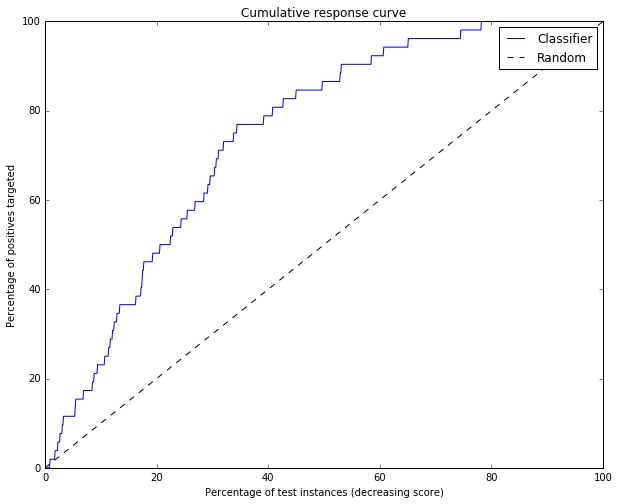

In [24]:
# Fit a logistic regression model
model = LogisticRegression(C=1.0)
model.fit(X_train, Y_train)

# Get the predicted value and the probability of Y_test records being = 1
Y_test_predicted = model.predict(X_test)
Y_test_probability_1 = model.predict_proba(X_test)[:, 1]

# Sort these predictions, probabilities, and the true value in descending order of probability
order = np.argsort(Y_test_probability_1)[::-1]
Y_test_predicted_sorted = Y_test_predicted[order]
Y_test_probability_1_sorted = Y_test_probability_1[order]
Y_test_sorted = np.array(Y_test)[order]

# Go record-by-record and build the cumulative response curve
x_cumulative = []
y_cumulative = []
total_test_positives = np.sum(Y_test)
for i in range(1, len(Y_test_probability_1_sorted)+1):
    x_cumulative.append(i)
    y_cumulative.append(np.sum(Y_test_sorted[0:i]) / float(total_test_positives))

# Rescale
x_cumulative = np.array(x_cumulative)/float(np.max(x_cumulative)) * 100
y_cumulative = np.array(y_cumulative) * 100

# Plot
plt.plot(x_cumulative, y_cumulative, label="Classifier")
plt.plot([0,100], [0,100], 'k--', label="Random")
plt.xlabel("Percentage of test instances (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.title("Cumulative response curve")
plt.legend()


We can also easily look at a lift curve in this scenario.

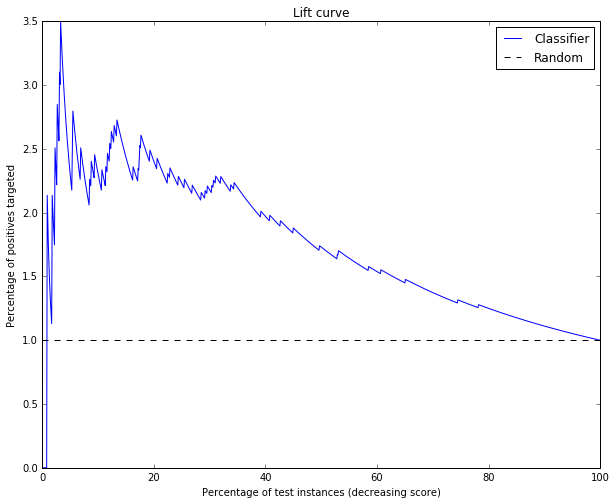

In [19]:
x_lift = x_cumulative
y_lift = y_cumulative/x_lift

plt.plot(x_lift, y_lift, label="Classifier")
plt.plot([0,100], [1,1], 'k--', label="Random")
plt.xlabel("Percentage of test instances (decreasing score)")
plt.ylabel("Percentage of positives targeted")
plt.title("Lift curve")
plt.legend()

### Hands-on

Now, let's use our code to make a bigger analysis!!

- Create the graph "Receiver operating characteristic (ROC) curves" including 3 Decision Tree Classifiers (3 different max depths)
- Which was your best max_depth ?
- Which model is better for this dataset, logistic regression or decision tree?



In [30]:
# Code here!